In [15]:
# Cell 1: Imports (same as original)
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import ResNet50  # Changed from DenseNet121
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.style.use('ggplot')

In [16]:
# Cell 2: Loading the Dataset (same as original)
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
img_size = (224, 224)
batch_size = 32

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # remaining 30% will be split into val+test
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Validation + Test dataset
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = int(0.5 * len(temp_ds))
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


In [18]:
# Cell 3: Data Augmentation and Preprocessing (same augmentation, but preprocess_input updated for ResNet)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

# Preprocessing for ResNet (normalize to ImageNet stats)
preprocess_input = tf.keras.applications.resnet.preprocess_input  # Changed from densenet

def prepare_train(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

def prepare_val_test(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y),  # Apply preprocess to val/test as well
                  num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = prepare_train(train_ds).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = prepare_val_test(val_ds).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = prepare_val_test(test_ds).cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Cell 4: Loading the Pre-trained Base Model (changed to ResNet50)
# Load ResNet50 Pretrained Model (with 'imagenet' weights)
base_model = ResNet50(  # Changed from DenseNet121
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

base_model.trainable = False # Freeze early layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Cell 5: Building the Full Model (preprocess_input already updated; rest same)
# Build improved classification head
inputs = base_model.input

# Preprocessing layer (already handled in dataset prep, but can keep if needed)
x = base_model(inputs, training=False)  # Keep batch norm in inference mode initially

# Enhanced classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Define full model
resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Renamed for clarity

In [22]:
# Cell 6: Defining Callbacks (same)
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8,
)

In [23]:
# Cell 7: Compiling the Model (same, but for resnet_model)
resnet_model.compile(  # Changed model name
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-4),
    metrics = ['accuracy'],
)

In [24]:
# Cell 8: Training the Model (same, but for resnet_model)
history = resnet_model.fit(  # Changed model name
    train_ds,
    epochs = 20,
    validation_data = val_ds,
    callbacks = [es, lr]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.2271 - loss: 2.3269 - val_accuracy: 0.4162 - val_loss: 1.5584 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.5063 - loss: 1.3901 - val_accuracy: 0.4872 - val_loss: 1.3491 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.6025 - loss: 1.1327 - val_accuracy: 0.5568 - val_loss: 1.1765 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.6437 - loss: 1.0039 - val_accuracy: 0.5511 - val_loss: 1.2127 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.6806 - loss: 0.9173 - val_accuracy: 0.5511 - val_loss: 1.2727 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.7309 - loss: 0.7800 - val_accuracy: 0.5469 - val_loss: 1.2247 - learning_rate: 1.0000e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - acc

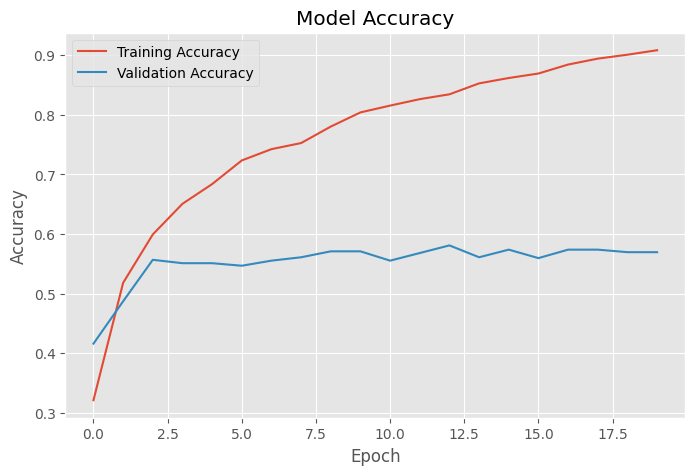

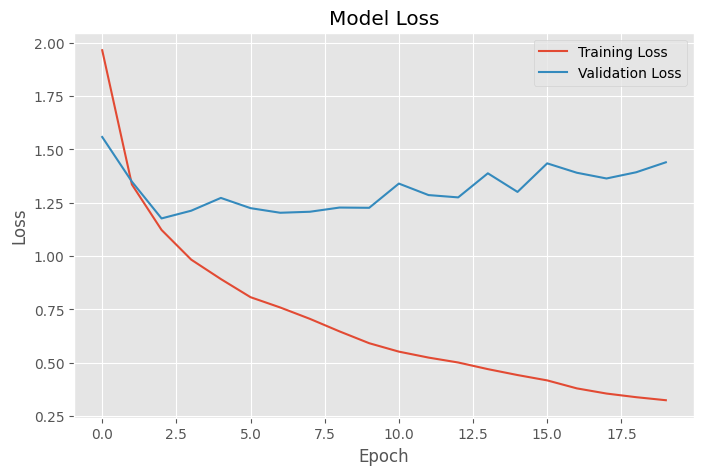

In [25]:
# Cell 9: Plotting Training History (same, but history from resnet_model)
# Extract history
history_dict = history.history  # Fixed: was dense_model.history.history, now from fit

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()